In [1]:
from IPython.display import HTML

# Projeto Final de Modelagem Matemática: Transformada de Radon

#### Leonardo Bohac

Neste projeto implementaremos a Transformada de Radon e a Transformada Inversa de Radon.

À título de contextualização, ressaltamos que estes métodos são amplamente utilizados em áreas da Ciência, principalmente na Medicina, com a finalidade de 'ver' o interior de um objeto (neste caso, partes do corpo humano) sem precisar obstruí-lo.

Na prática, a Transformada de Radon é feita não através de um algoritmo, mas sim pela própria física das máquinas de escaneamento (raio-X, ressonância magnética, etc.). Coloca-se o corpo no centro de detecção, e ondas eletromagnéticas viajam de uma fonte emissora à uma fonte receptora, atravessando o corpo. A partir da intensidade das ondas recebidas é possível inferir a densidade do corpo, acumulada ao longo da direção de emissão. Este processo de medição de intensidade é realizado para diferentes direções e deslocamentos com relação ao centro do corpo, obtendo-se a sua chamada Transformada de Radon. Veja abaixo este mecanismo em ação:

In [2]:
HTML('<img src="./circle.gif">')

O objeto sendo escaneado acima é um círculo de densidade uniforme. Note que, devido à total simetria do círculo, a distribuição de densidade acumulada é a mesma para qualquer ângulo de emissão. Também pode-se perceber que, quanto menor o deslocamento das ondas com relação ao centro do círculo, maior a densidade acumulada, sendo essa máxima onde o deslocamento é nulo, ou seja, nas ondas que passam exatamente sobre o seu diâmetro. 

In [3]:
HTML('<img src="./squares.gif">')

O objeto acima é representado por 4 quadrados. Os quadrados claros possuem densidade uniforme positiva e os quadrados escuros possuem densidade nula. Aqui é interessante observar que o ponto de maior intensidade na Transformada ocorre no ângulo $\frac{\pi}{4}$ e deslocamento $0$, representando a diagonal da imagem que passa pela maior quantidade de pontos claros.

O código para o cálculo da Transformada está documentado abaixo:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
linspace = np.linspace
array    = np.array
sqrt     = np.sqrt
cos      = np.cos
sin      = np.sin
pi       = np.pi

In [6]:
N = 128          # Dimensão da Imagem (N x N)

eps = 2/(N-1)

nA = N           # quantidade de ângulos para percorrer
nD = int(1.5*N)  # quantidade de deslocamentos
nL = int(1.5*N)  # quantidade de pontos por linha

In [7]:
U = linspace(-1, 1, N)

A = linspace(0, pi, nA).reshape(-1,1)

D = linspace(-1.5, 1.5, nD)

L = linspace(-1.5, 1.5, nL)

dl = L[1]-L[0]

### Função (Imagem) Original:

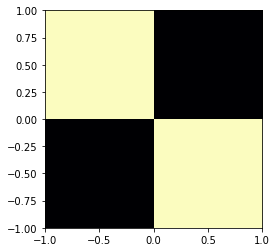

In [8]:
X = np.meshgrid(U,U)[1]
Y = np.meshgrid(U,U)[0]

F_Original = np.where((X*Y < 0), 1, 0)

plt.imshow(F_Original[::-1], extent=[-1,1,-1,1], cmap='magma');

### Cálculo da Transformada:

In [9]:
# Adicionando uma linha e uma coluna de zeros na imagem, para lidar com pontos de linhas que não passam na imagem. 

F = np.vstack((F_Original,np.zeros(N)))
F = np.hstack((F, np.zeros(N+1).reshape(-1,1)))

In [10]:
G = np.meshgrid(L,D)

GD = G[1].flatten()
GL = G[0].flatten()

LX = (GD*cos(A)-GL*sin(A)).reshape(nA,nD,nL)   # coordenadas-x de todas as linhas que serão consideradas
LY = (GD*sin(A)+GL*cos(A)).reshape(nA,nD,nL)   # coordenadas-y de todas as linhas que serão consideradas

In [11]:
IX = np.floor((LX+1)/eps).astype(np.int64)     # convertendo coordenadas-x em índices de U
IY = np.floor((LY+1)/eps).astype(np.int64)     # convertendo coordenadas-y em índices de U

IX = np.where((IX>=0)&(IX<N)&(IY>=0)&(IY<N), IX, -1)  # pontos que passam fora da imagem terão índice -1
IY = np.where((IX!=-1), IY, -1)

### Transformada:

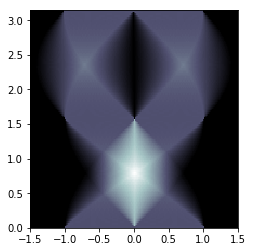

In [12]:
R = np.sum(F[IY,IX],axis=2)*dl   # integral ao longo de todas as linhas

plt.imshow(R[::-1], extent=[-1.5, 1.5, 0, pi], cmap='bone');

A maior importância da Transformada de Radon não é a Transformada em si, mas sim a sua Transformada Inversa, que torna possível reconstruir a formação no interior de objetos.

Optamos em utilizar um algoritmo próprio (que na verdade se mostrou depois um algoritmo já existente) para realizar seu cálculo.

A idéia é que cada ponto na Transformada representa uma integral sobre uma linha da imagem, e cada uma destas integrais possui uma contribuição de determinados pontos da imagem. Podemos então criar uma matriz, cujo número de colunas é o número total de pontos na imagem ($N^2$), e o número de linhas (da matriz) é o número de linhas das quais as integrais foram medidas (nA x nD).

Percorrendo estas linhas, adicionamos a contribuição de cada ponto em sua coluna correspondente. Quando um ponto não exerce contribuição sobre uma determinada linha, o valor da coluna correspondente é zero.

Tendo então essa matriz $Q$ (bastante esparsa e não-quadrada), encontramos através do método dos mínimos-quadrados, a solução que melhor aproxima a equação:

$$ Q \cdot x = V$$

onde $x$ é o vetor de dimensão $N^2$ que gostaríamos de descobrir, e $V$ é a Transformada "achatada" (um vetor de dimensão nA x nD).

### Cálculo da Inversa:

In [13]:
from scipy.sparse import lil_matrix 
from scipy.sparse.linalg import lsmr

In [14]:
Q = lil_matrix((nA*nD, N*N))
V = []

r = 0
for i in range(nA):
    
    for j in range(nD):
            
        ix = IX[i][j]
        iy = IY[i][j]

        P  = (N+1)*iy + ix   # transformando os índices bi-dimensionais em índices unidimensionais

        if(np.any(P!=(N+1)*N+N)):  # confere se a linha correspondente possui algum ponto que passa dentro da imagem

            for p in range(nD):

                if(P[p]!=(N+1)*N+N): # confere se o ponto em questão passa dentro da imagem

                    c = N*iy[p] + ix[p]  # cálculo da coluna correspondente ao ponto em questão
                    
                    Q[r,c] += 1          # adiciona a contribuição do ponto

            V.append(R[i][j])  # achatamento da Transformada
            
            r += 1

Q = Q[:r,:]  # considerando somente as linhas não-nulas
V = array(V)

In [15]:
Z = lsmr(Q,V)[0].reshape(N,N)/dl       # resolução por mínimos-quadrados

### Inversa ($\approx$Função Original):

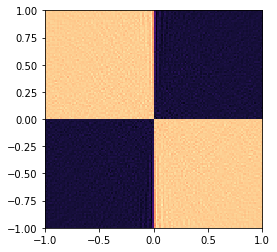

In [16]:
plt.imshow(Z[::-1],extent=[-1,1,-1,1], cmap='magma');

#### Resíduo (Função Original - Inversa):

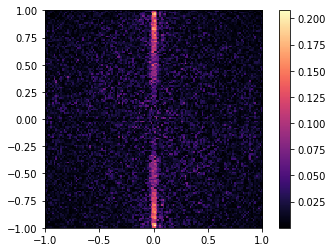

In [17]:
plt.imshow(np.abs(Z-F_Original)[::-1], extent=[-1,1,-1,1], cmap='magma');
plt.colorbar();